## Reproducibility of the plots of the paper
## Persistent Topological Features in Large Language Models

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import post_process
from post_process import POSTPROCESS
import pandas as pd
import os
import glob

### Setting up colors

In [16]:
hex6 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
colors6=[mcolors.to_rgb(i) for i in hex6]

colors = ['white', colors6[2]]
positions = [0, 1]
cmap0 = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))

In [17]:
cb_palette = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000', '#3CAB20', '#6B750C', '#A6761D', '#D8A21E', '#F0E442',
              '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

### Compute the descriptors used in the paper (Inter-layer Similarity, )

In [18]:
def inter_layer_persistance(model,num_layers,p=1):

    pds = post_process.read_pd_from_csv(model, max_dim = 5)
    pp = POSTPROCESS(pds = pds, num_layers = num_layers*2, start_ind = 1, zigzag = True, debug = False)
    psim = pp.find_ph_sim()[p]
    bettis = pp.find_betti_layers()[p]
    temp = np.zeros((num_layers,num_layers))
    for i in range(num_layers):
        if bettis[i] == 0:
            temp[i] = 0
        else:
            temp[i] = psim[i]/bettis[i]
    return temp

In [19]:
def weighed_inter_layer_persistance(layer_pers,n_layers,p=1):
    weights = np.zeros((n_layers,n_layers))
    for i in range(n_layers):
        for j in range(n_layers):
                if p < 0 and i == j:
                    weights[i][j] = 1e-10
                else:
                    weights[i][j] = np.abs(i-j)**p
    return np.sum(layer_pers*weights,axis=1)/np.sum(weights,axis=1)


In [20]:
def pi_hist(model,num_layers,p=2,axis=1):
    weights = np.zeros((num_layers,num_layers))
    for i in range(num_layers):
        for j in range(num_layers):
                if p < 0 and i == j:
                    weights[i][j] = 1e-10
                else:
                    weights[i][j] = np.abs(i-j)**p
    pis = effective_pi(model,num_layers)
    pis_hist = np.sum(pis*weights,axis=axis)/np.sum(weights,axis=axis)
    # Normalize pis_hist to 1
    pis_hist /= np.sum(pis_hist)
    return pis_hist

In [21]:
def effective_pi(model,num_layers,p=1):
    pds = post_process.read_pd_from_csv(model, max_dim = 5)
    pp = POSTPROCESS(pds = pds, num_layers = num_layers*2, start_ind = 1, zigzag = True, debug = False)
    pis = pp.find_eff_pis()[p]
    pis_pers = np.zeros((num_layers,num_layers))
    pis_death = np.zeros((num_layers,num_layers))
    for i in range(num_layers):
        for j in range(num_layers):
            if i-j>=0:
                pis_pers[i-j,j] = pis[i,j]
            pis_death[i,j] = pis[i,j]
    return pis_death

## Figure 2

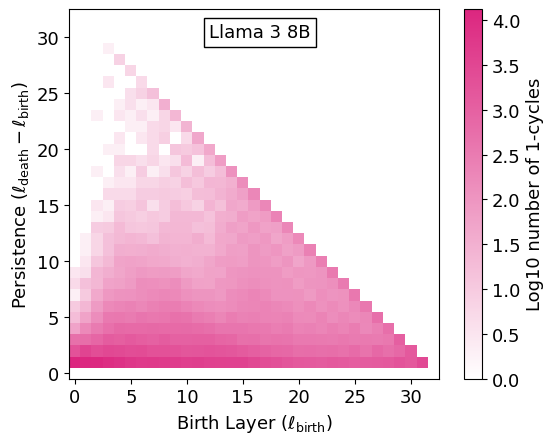

In [22]:
model = './csv/sst/llama_3_8b_dim_4_knn_5_last_token.csv'
num_layers = 33 

pds = post_process.read_pd_from_csv(model, max_dim = 5)
pp = POSTPROCESS(pds = pds, num_layers = num_layers*2, start_ind = 1, zigzag = True, debug = False)
pis = pp.find_eff_pis()[1]
bettis = pp.find_betti_layers()[1]
import warnings
warnings.filterwarnings('ignore')
pis_pers = np.zeros((len(pis),num_layers,num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        if i-j>=0:
            pis_pers[:,i-j,j] = pis[i,j]


plt.imshow(np.log10(pis_pers[1]), cmap=cmap0, origin='lower')
cb = plt.colorbar()
cb.set_label('Log10 number of 1-cycles',fontsize=13)
cb.ax.tick_params(labelsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Birth Layer $(\\ell_{\\rm birth})$',fontsize=13)
plt.ylabel('Persistence $(\\ell_{\\rm death} - \\ell_{\\rm birth})$',fontsize=13)
plt.text(12,30,'Llama 3 8B',fontsize=13,bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))
plt.show()

## Figure 3

In [27]:
split_500_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/16_split/*')

### Left plot

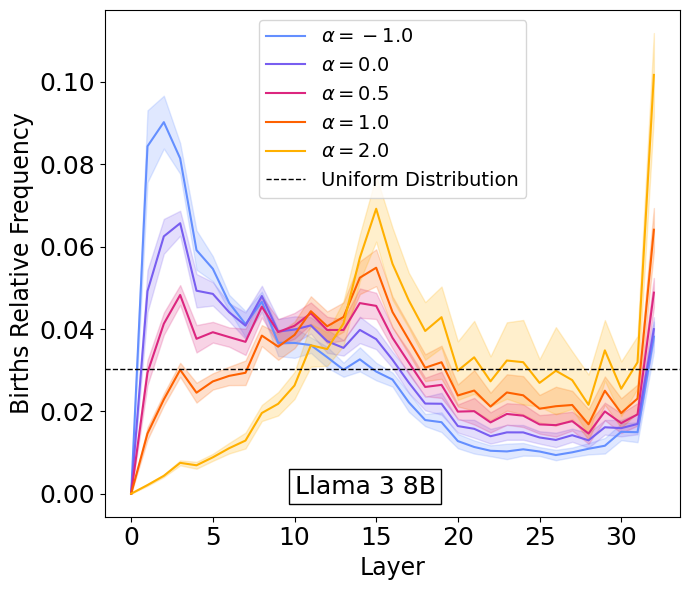

In [28]:
plt.figure(figsize=(7, 6))
ps = [-1., 0, 0.5, 1, 2]
for p in ps:  
    pi_hist500_llama3 = []
    for model in split_500_llama3b:
        pi_hist500_llama3.append(pi_hist(model, num_layers,p))

    pi_hist500_llama3_mean = np.mean(pi_hist500_llama3, axis=0)
    pi_hist500_llama3_std = np.std(pi_hist500_llama3, axis=0)

    x = np.arange(num_layers)
    plt.plot(x, pi_hist500_llama3_mean, color=cb_palette[ps.index(p)], label='$\\alpha=%.1f$'%p)
    plt.fill_between(x, pi_hist500_llama3_mean - pi_hist500_llama3_std, pi_hist500_llama3_mean + pi_hist500_llama3_std, color=cb_palette[ps.index(p)], alpha=0.2)
plt.axhline(y=1/num_layers, label='Uniform Distribution',color='black', linestyle='--',lw=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(10, 0, 'Llama 3 8B', fontsize=18, bbox=dict(facecolor='white'))
plt.xlabel('Layer', fontsize=17)
plt.ylabel('Births Relative Frequency', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Middle plot

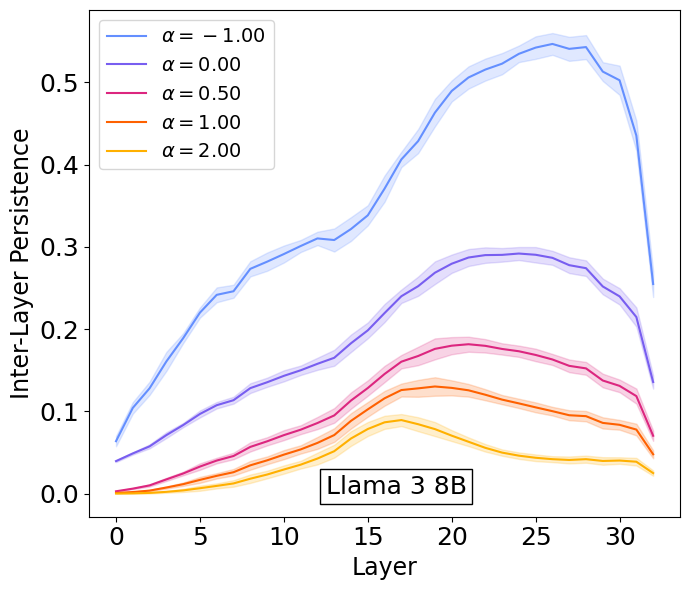

In [41]:
plt.figure(figsize=(7, 6))
ps = [-1., 0., 0.5, 1, 2]
#ps = [0,0.1,0.25,0.5,1,2]
for p in ps:
    avgsim_llama3 = []

    for model in split_500_llama3b:
        avgsim_llama3.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))

    avgsim_llama3_mean = np.mean(avgsim_llama3, axis=0)
    avgsim_llama3_std = np.std(avgsim_llama3, axis=0)

    x = np.arange(num_layers)
    plt.plot(x, avgsim_llama3_mean, color=cb_palette[ps.index(p)], label='$\\alpha=%.2f$'%p)
    plt.fill_between(x, avgsim_llama3_mean - avgsim_llama3_std, avgsim_llama3_mean + avgsim_llama3_std, color=cb_palette[ps.index(p)], alpha=0.2)
plt.text(12.5, 0, 'Llama 3 8B', fontsize=18, bbox=dict(facecolor='white'))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Layer', fontsize=17)
plt.ylabel('Inter-Layer Persistence', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Right plot

In [42]:
p = 2

In [43]:
## load data
split_500_llama2b = glob.glob('./csv/split_sst/llama2-7b/knn4/16_split/*')
split_500_mistral = glob.glob('./csv/split_sst/mistral/knn4/16_split/*') 
split_500_pythia  = glob.glob('./csv/split_sst/pythia/knn4/16_split/*')

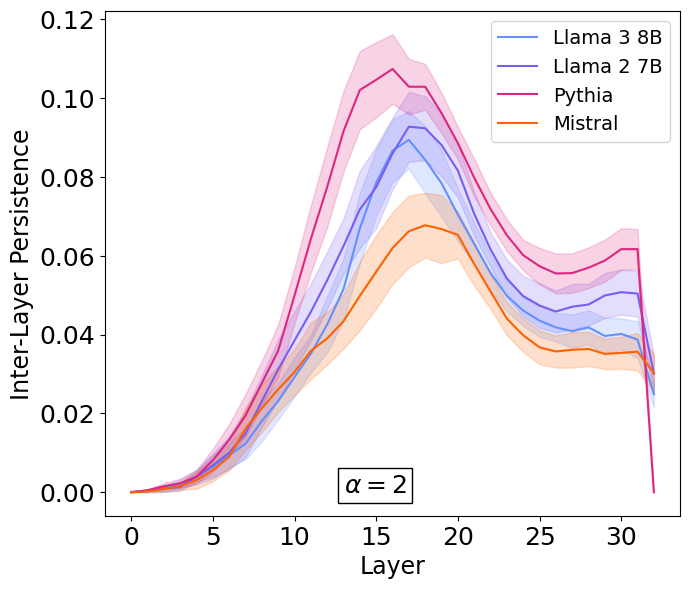

In [44]:
num_layers = 33 
avgsim_llama3  = []
avgsim_llama2  = []
avgsim_pythia  = []
avgsim_mistral = []



for model in split_500_llama3b:
    avgsim_llama3.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_500_llama2b:
    avgsim_llama2.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_500_pythia:
    avgsim_pythia.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_500_mistral:
    avgsim_mistral.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))    

avgsim_llama3_mean = np.mean(avgsim_llama3, axis=0)
avgsim_llama3_std = np.std(avgsim_llama3, axis=0)
avgsim_llama2_mean = np.mean(avgsim_llama2, axis=0)
avgsim_llama2_std = np.std(avgsim_llama2, axis=0)
avgsim_pythia_mean = np.mean(avgsim_pythia, axis=0)
avgsim_pythia_std = np.std(avgsim_pythia, axis=0)
avgsim_mistral_mean = np.mean(avgsim_mistral, axis=0)
avgsim_mistral_std = np.std(avgsim_mistral, axis=0)

#[mean,std,label,color]
models = [[avgsim_llama3_mean,avgsim_llama3_std,'Llama 3 8B',cb_palette[0]],
          [avgsim_llama2_mean,avgsim_llama2_std,'Llama 2 7B',cb_palette[1]],
          [avgsim_pythia_mean,avgsim_pythia_std,'Pythia',cb_palette[2]],
          [avgsim_mistral_mean,avgsim_mistral_std,'Mistral',cb_palette[3]]
         ]
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
x = np.arange(num_layers)

for m in models:
    ax.plot(x, m[0], color=m[3], label=m[2])
    ax.fill_between(x, m[0] - m[1], m[0] + m[1], color=m[3], alpha=0.2)


ax.set_xticks(np.arange(0, num_layers, 5))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.text(13, 0, '$\\alpha = %d$' % p, bbox=dict(facecolor='white', alpha=1.0), fontsize=18)
ax.set_xlabel('Layer', fontsize=17)
ax.set_ylabel('Inter-Layer Persistence', fontsize=17)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()

